# Backpropagation through the void

[Open Review](https://openreview.net/forum?id=SyzKd1bCW&noteId=SyzKd1bCW)

Problem statement: optimize the parameters of a distribution to maximize an expectation

Objective

$$
    \theta^\star = \mathrm{argmax}_\theta \mathbb{E}_{b \sim p(b|\theta)} \left[ f(b) \right]
$$


## Score function trick

Also called REINFORCE.

$$
    \frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \big[ f(b) \big] =
    \mathbb{E}_{p(b|\theta)} \big[ f(b) \frac{\partial}{\partial \theta} \log p(b|\theta) \big] 
$$


## Reparametrization Trick

Assume $p(b|\theta)$ can be expressed as the determinstic transform of non-parametrized random variable $\epsilon \sim p(\epsilon), T(\epsilon|\theta) \sim p(b|\theta)$.

$$
    \frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \big[ f(b) \big] =
    \mathbb{E}_{p(\epsilon)} \big[ \frac{\partial}{\partial \theta}  f(T(\epsilon|\theta)) \big]
$$

## LAX

Mix score function and reparametrization for non-differentiable $f$, but reparametrizable $b$. Introduce control-variates $c_\phi(b)$.

$$
\begin{align}
    \frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \big[ f(b) \big]
    &= \mathbb{E}_{p(b|\theta)} \big[ 
        g_\mathrm{score}[f] - g_\mathrm{score}[c_\phi] + g_\mathrm{reparam}[c_\phi] 
    \big]
\\
    &= \mathbb{E}_{p(\epsilon)} \big[ 
        (f(T(\epsilon, \theta)) - c_\phi(T(\epsilon, \theta))) 
        \frac{\partial}{\partial \theta} \log p(T(\epsilon, \theta)|\theta) +
        \frac{\partial}{\partial \theta} c_\phi(T(\epsilon, \theta)|\theta)
    \big]
\end{align}
$$

## RELAX

Introduce continuous relaxation in addition to LAX for non-differentiable $f$, but non-reparametrizable $b$.

Write the sampling process as the deterministic transformation ($H$) of a continuous variable ($z$):

$$
\begin{align}
    z &\sim p(z |\theta) \\
    b &= H(z) \sim p(b |\theta) \\
    \tilde{z} &\sim p(\tilde{z}|b, \theta)
\end{align}
$$

The gradient estimates is then written as:
$$
\begin{align}
    \frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \big[ f(b) \big]
    &= \mathbb{E}_{p(b|\theta)} \big[ 
        g_\mathrm{score}[f] - g_\mathrm{score}[c_\phi(\tilde{z})] 
        + g_\mathrm{reparam}[c_\phi] 
        - g_\mathrm{reparam}[c_\phi(\tilde{z})]
    \big]
\end{align}
$$

The last term corrects the error made, when using the $\tilde{z}$ in the score function estimator. By using $\tilde{z}$ in score function estimator, RELAX reduces to the reparametrization trick for $c_\phi = f$.
Note, that in this expression $b$ is fixed throughout. Therefore when backpropagating through $\tilde{z}$, no gradient through $b$ is taken.
The estimator is unbiased as can be shown via:

$$
    \frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \big[ f(b) \big] = 
    \mathbb{E}_{p(z|\theta)} \big[
        (f(b) - c_\phi(\tilde{z})) \frac{\partial}{\partial \theta} \log p(b|\theta) +
        \frac{\partial}{\partial \theta} c_\phi(z) -
        \frac{\partial}{\partial \theta} c_\phi(\tilde{z})
    \big]
$$

Both $p(z| \theta)$ and $p(\tilde{z}|b, \theta)$ are re-parametrizable.

## How to choose the control variate?

The paper explorese two options: 

- learning the control variate by minimizing a one-sample estimate of the variance
- using a smoothed version of the original loss, i.e., replacing all categoricla variables with smoothed versions sampled via the Gumbel-softmax trick. In that case, the temperature can still be learned to minimize the variance.

## Summary

|              |f diff.       |f non-diff.|
|--------------|--------------|-----------|
|b reparam.    |reparam. trick|    LAX    |
|b non-reparam.|    RELAX     |   RELAX   |


# Continuous relaxations of discrete variables

## Relaxation of binary variables

[REBAR: Low-variance, unbiased gradient estimates for discrete latent variable models](https://arxiv.org/abs/1703.07370): Binary relaxation with control variates for variance reduction.

Based on sampling approach, $b = H(p - u)$, with $H(x) = 1\;\mathrm{if}\;x > 0\;\mathrm{else}\;0$ and $u \sim \mathrm{Uniform(0, 1)}$.

Given the inequality $u < p$, any monotonic transformation does not change the outcome. Here use the logit transform $\mathrm{logit}(p) = \log \frac{p}{1 - p}$. This gives $\mathrm{logit}(u) < \mathrm{logit}(p)$. Observe that for $u \sim \mathrm{Uniform(0, 1)}$:

$$
    -\mathrm{logit}(u) = \mathrm{logit}(1 - u) = \mathrm{logit}(u^\prime),
$$

with $u^\prime \sim \mathrm{Uniform}(0, 1)$.

Thefore we can sample $b$ as

$$
    b = H(\log \frac{p}{1 - p} + \log \frac{u}{1 - u}).
$$

Finally, the Heavyside step function can be relaxed into a sigmoid to allow backprop through the binary variable. This results in a low variance, but biased estimator. As an alternative, the continuous relaxation can be used as a control variate. This will result in an unbiased estimator with low variance.

To sample $z| b$, note that

$$
\begin{align}
    z(u^\prime) &= 0
\\
    u^\prime = 1 - p
\end{align}
$$

By analogy to rejection sampling, one finds that $u \sim \mathrm{Uniform}(1 - p, 1)$ for $b = 1$ and 
$u \sim \mathrm{Uniform}(0, 1 - p)$ for $b = 0$. Thereby $z$ can be sampled as:

$$
\begin{align}
    z = \mathrm{logit}(p) + b \mathrm{logit}(1 - v p) + (1 - b) \mathrm{logit}(v(1 - p)),
\end{align}
$$

with $v \sim \mathrm{Uniform}(0, 1)$.


In [4]:
%matplotlib inline

In [193]:
from chmp.ds import reload

reload('chmp.ds')
from chmp.ds import mpl_set, path, axtext, get_color_cycle, define

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
z = np.linspace(-3, 3, 100)

In [4]:
u = np.random.uniform(size=(z.size, 1000))
u = np.clip(u, 1e-9, 1 - 1e-9)

In [161]:
theta = 1.0 / (1.0 + np.exp(-z[:, None]))
theta = theta + 0 * u

In [149]:
actual_b = (z[:, None] + np.log(u / (1 - u))) > 0
actual_b_mean = np.mean(actual_b, axis=1)
actual_b_std = np.std(actual_b, axis=1)

expected_b_mean = 1.0 / (1.0 + np.exp(-z))
expected_b_std = np.sqrt(expected_b_mean * (1.0 - expected_b_mean))

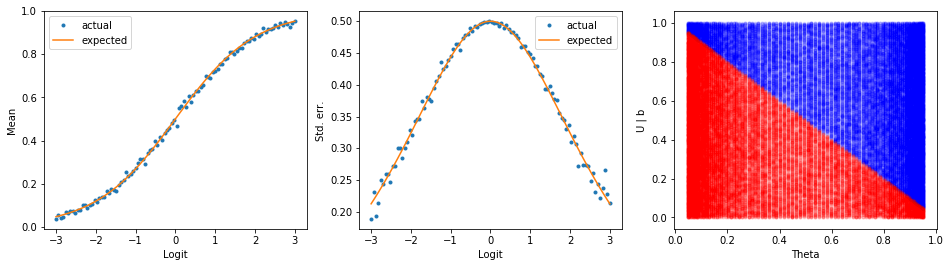

In [168]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(z, actual_b_mean, ".", label='actual')
plt.plot(z, expected_b_mean, label='expected')
mpl_set(legend=True, xlabel='Logit', ylabel='Mean')

plt.subplot(1, 3, 2)
plt.plot(z, actual_b_std, '.', label='actual')
plt.plot(z, expected_b_std, label='expected')
mpl_set(legend=True, xlabel='Logit', ylabel='Std. err.')

plt.subplot(1, 3, 3)
plt.scatter(theta[actual_b == 1], u[actual_b == 1], alpha=0.05, marker='.', color='b')
plt.scatter(theta[actual_b == 0], u[actual_b == 0], alpha=0.05, marker='.', color='r')
mpl_set(xlabel='Theta', ylabel='U | b')

## Continous Relaxation of categorical variables

Sample $z$ as

$$
    z_i = log \pi_i - \log (-\log u_i)
$$

Then categorical can be determined as $b = \mathrm{argmax}\; z_i$.

To sample $z|b$, note that we have to ensure $z_b > z_i\; \forall i \neq b$. This leads to the following condition on the $u_i$:

$$
\begin{align}
    z_i &< z_b \\
    \log \theta_i + g_i &< \log \theta_b + g_b \\
    \log \frac{\theta_i}{\theta_j} &< \log \frac{\log u_i}{\log u_b} \\
    \frac{\theta_i}{\theta_j} &< \frac{\log u_i}{\log u_b} \\
    \frac{\theta_i}{\theta_j} \log u_b &> \log u_i \\
    u_b^{\theta_i / \theta_j} &> u_i
\end{align}
$$

This can easily be sampled setting:

$$
    u_i := \begin{cases}
        u_i & \text{if $i = b$} \\
        u_i u_b^{\theta_i / \theta_j}
    \end{cases}
$$

This result can be found in app. B of "Backporpagation through the void".

In [63]:
np.random.seed(13)
pi = np.random.dirichlet(alpha=[0.4] * 3)

In [134]:
triangle = np.asarray([
    (0, 0), 
    (1, 0), 
    (np.cos(2 * np.pi / 6), np.sin(2 * np.pi / 6)),
])

T = np.asarray([
    triangle[:, 0],
    triangle[:, 1],
    np.ones(3),
])

In [133]:
def softmax(x, axis=-1):
    xmax = np.max(x, axis=axis, keepdims=True)
    x = x - xmax
    x = np.exp(x)
    x = x / np.sum(x, axis=axis, keepdims=True)
    return x

In [137]:
np.random.seed(42)
u = np.random.uniform(size=(3, 1000))
z = np.log(pi[:, None]) - np.log(-np.log(u))

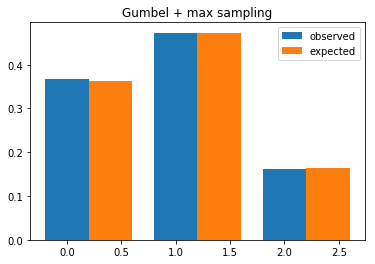

In [144]:
plt.title('Gumbel + max sampling')
plt.bar(np.arange(3), np.bincount(np.argmax(z, axis=0)) / 1000, width=0.4, label='observed')
plt.bar(np.arange(3) + 0.4, pi, width=0.4, label='expected')
plt.legend()
pass

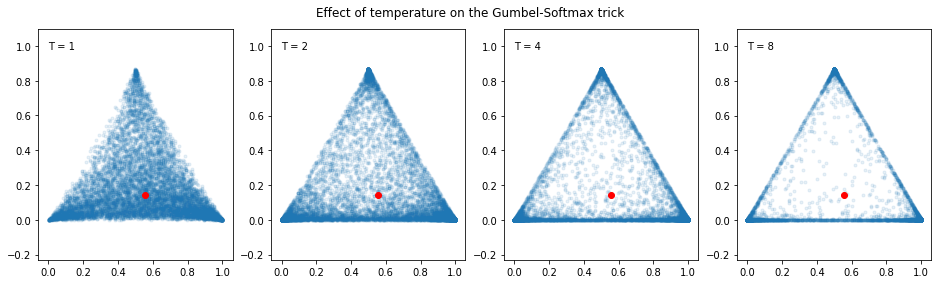

In [196]:
@define
def _plot():
    plt.figure(figsize=(16, 4))
    plt.subplots_adjust(top=0.90, bottom=0.1)
    for idx, temp in enumerate([1, 2, 4, 8]):
        x, y, _ = np.dot(T, pi)
        z_x, z_y, _ = np.dot(T, softmax(temp * z, axis=0))

        plt.subplot(1, 4, 1 + idx)
        plt.scatter(z_x, z_y, alpha=0.1, marker='.')
        plt.scatter([x], [y], color='r')
        axtext(0.05, 0.95, f'T = {temp}', va='top', ha='left')
        plt.axis('equal')

    plt.suptitle('Effect of temperature on the Gumbel-Softmax trick')

In [216]:
np.random.seed(42)
u = np.random.uniform(size=(3, 10000))

z = np.log(pi[:, None]) - np.log(-np.log(u))

reject_u_given2 = u[:, np.argmax(z, axis=0) == 2]

scaled_u_given2 = np.copy(u)
scaled_u_given2[0, :] = scaled_u_given2[0, :] * (scaled_u_given2[2, :] ** (pi[0] / pi[2]))
scaled_u_given2[1, :] = scaled_u_given2[1, :] * (scaled_u_given2[2, :] ** (pi[1] / pi[2]))

reject_z_given2 = np.log(pi[:, None]) - np.log(-np.log(reject_u_given2))
reject_b_given2 = softmax(reject_z_given2, axis=0)

scaled_z_given2 = np.log(pi[:, None]) - np.log(-np.log(scaled_u_given2))
scaled_b_given2 = softmax(scaled_z_given2, axis=0)

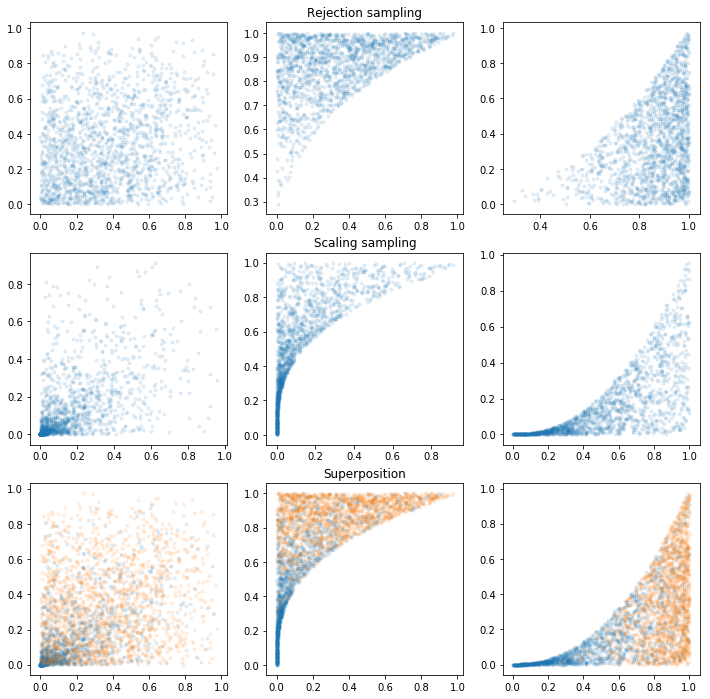

In [200]:
@define
def _plot():
    blue, green = get_color_cycle(2)
    
    plt.figure(figsize=(12, 12))
    for idx in range(3):
        plt.subplot(3, 3, 1 + idx)
        plt.scatter(
            reject_u_given2[(idx + 0) % 3, :], reject_u_given2[(idx + 1) % 3, :], 
            alpha=0.1, marker='.',
        )
        if idx == 1:
            plt.title('Rejection sampling')

        plt.subplot(3, 3, 4 + idx)
        plt.scatter(
            scaled_u_given2[(idx + 0) % 3, :reject_u_given2.shape[1]], 
            scaled_u_given2[(idx + 1) % 3, :reject_u_given2.shape[1]], 
            alpha=0.1, marker='.',
        )
        if idx == 1:
            plt.title('Scaling sampling')


        plt.subplot(3, 3, 7 + idx)
        plt.scatter(
            scaled_u_given2[(idx + 0) % 3, :reject_u_given2.shape[1]], 
            scaled_u_given2[(idx + 1) % 3, :reject_u_given2.shape[1]], 
            alpha=0.1, marker='.', color=blue,
        )
        plt.scatter(
            reject_u_given2[(idx + 0) % 3, :], reject_u_given2[(idx + 1) % 3, :], 
            alpha=0.1, marker='.', color=green,
        )
        if idx == 1:
            plt.title('Superposition')

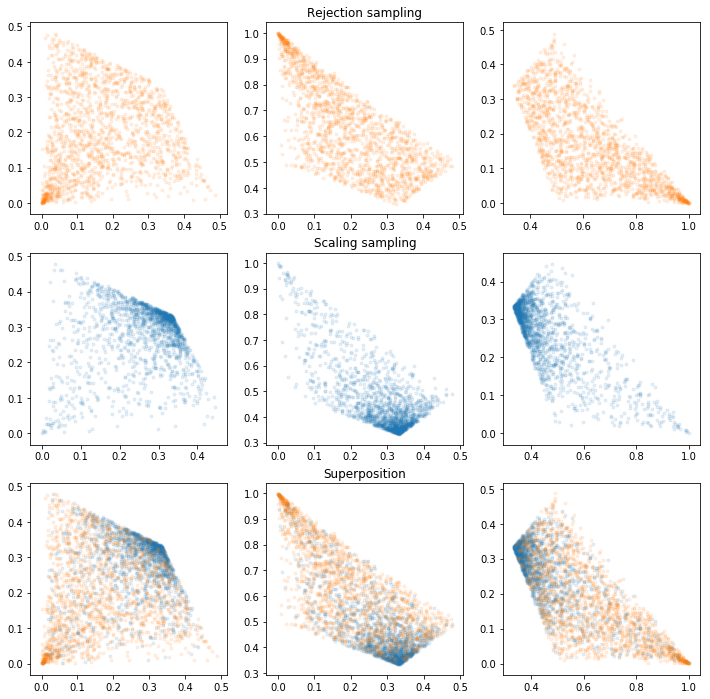

In [217]:
@define
def _plot():
    blue, green = get_color_cycle(2)
    _, N = reject_b_given2.shape
    
    plt.figure(figsize=(12, 12))
    for idx in range(3):
        plt.subplot(3, 3, 1 + idx)
        plt.scatter(
            reject_b_given2[(idx + 0) % 3, :], reject_b_given2[(idx + 1) % 3, :], 
            alpha=0.1, marker='.', color=green,
        )
        if idx == 1:
            plt.title('Rejection sampling')

        plt.subplot(3, 3, 4 + idx)
        plt.scatter(
            scaled_b_given2[(idx + 0) % 3, :N], scaled_b_given2[(idx + 1) % 3, :N], 
            alpha=0.1, marker='.', color=blue,
        )
        if idx == 1:
            plt.title('Scaling sampling')


        plt.subplot(3, 3, 7 + idx)
        plt.scatter(
            scaled_b_given2[(idx + 0) % 3, :N],  scaled_b_given2[(idx + 1) % 3, :N], 
            alpha=0.1, marker='.', color=blue,
        )
        plt.scatter(
            reject_b_given2[(idx + 0) % 3, :], reject_b_given2[(idx + 1) % 3, :], 
            alpha=0.1, marker='.', color=green,
        )
        if idx == 1:
            plt.title('Superposition')

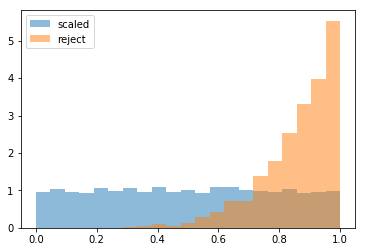

In [231]:
@define
def _plot():
    blue, green = get_color_cycle(2)
    plt.hist(
        scaled_u_given2[2, :], 
        bins=21, range=(0, 1), alpha=0.5, normed=True, color=blue, label='scaled',
    )
    plt.hist(
        reject_u_given2[2, :], 
        bins=21, range=(0, 1), alpha=0.5, normed=True, color=green, label='reject',
    )
    mpl_set(legend=True)

# Toy problem

In [40]:
t = np.linspace(0.1, 0.9, 9)
theta = np.linspace(0.1, 0.9, 9)

In [45]:
b = np.random.binomial(n=1, p=theta[:, None], size=(9, 1000))

In [50]:
loss = np.mean((b[None, ...] - t[:, None, None]) ** 2.0, axis=2)

In [77]:
def edges(x):
    """Create edges for use with pcolor.
    
    Usage::
        
        assert x.size == v.shape[1]
        assert y.size == v.shape[0]
        pcolor(edges(x), edges(y), v)
        
    """
    centers = 0.5 * (x[1:] + x[:-1])
    return np.concatenate((
        [x[0] - 0.5 * (x[1] - x[0])], 
        centers,
        [x[-1] + 0.5 * (x[-1] - x[-2])]
    ))

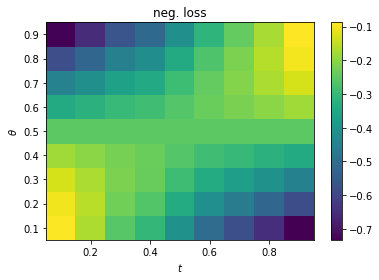

In [78]:
plt.pcolor(edges(t), edges(theta), -loss)
mpl_set(xlabel='$t$', ylabel=r'$\theta$', title='neg. loss', colorbar=True)

Reinforce:

$$
    \log p(b|\theta) = b \log \theta + (1 - b) \log \left( 1 - \theta \right)
$$

$$
\begin{align}
\frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \left( t - b \right)^2 
    &= \mathbb{E}_{p(b|\theta)} \left[ 
        \left( t - b \right)^2 \frac{\partial}{\partial \theta} \log p(b|\theta) 
    \right] 
\\
    &= \mathbb{E}_{p(b|\theta)} \left[ 
        \left( t - b \right)^2 \left( \frac{b}{\theta} - \frac{1 - b}{1 - \theta} \right)
    \right]
\\
    &= (t - 1)^2  - t^2 = 1 - 2t
\end{align}
$$

Continuous relaxation (biased):

$$
\begin{align}
\frac{\partial}{\partial \theta} \mathbb{E}_{p(b|\theta)} \left( t - b \right)^2   
    &\approx
        \frac{\partial}{\partial \theta} 
        \mathbb{E}_{u \sim \mathcal{U}} \left( 
            t - \sigma_\lambda(\mathrm{logit}(\theta) + \mathrm{logit}(u))
        \right)^2 
\end{align}
$$


In [81]:
import tensorflow as tf

In [148]:
def logit(x):
    return tf.log(x / (1 + x))

def safe_uniform(shape):
    return tf.random_uniform(shape, 1e-8, 1 - 1e-8)

In [123]:
tf.reset_default_graph()
theta_ = tf.get_variable('theta', dtype=tf.float32, initializer=np.asarray(0.6, dtype=np.float32))
t_ = tf.placeholder(name='t', dtype=tf.float32, shape=[])

# samples
b_ = tf.placeholder(name='b', shape=[None], dtype=tf.float32)

log_p_ = b_ * tf.log(theta_) + (1 - b_) * tf.log(1 - theta_)
loss_ = tf.reduce_mean((t_ - b) ** 2.0)
loss_score_grad_ = tf.reduce_mean((t_ - b) ** 2.0 * tf.gradients(log_p_, theta_))

In [141]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    loss_score_grad = [
        session.run(loss_score_grad_, {
            b_: np.random.binomial(n=1, p=0.6, size=500),
            t_: 0.45,
        })
        for _ in range(5000)
    ]

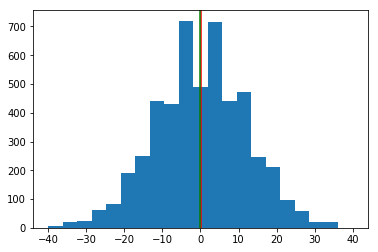

In [146]:
plt.hist(loss_score_grad, bins=21, range=(-40, +40))
plt.axvline(np.mean(loss_score_grad), color='r')
plt.axvline(1 - 2 * 0.6, color='g')